In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import community as community_louvain


from helpers import generate_embedding
from graph_role_extraction import find_k_clusters, find_optimal_clusters, HellingerPCs

# Data

Running the below code requires data for the full airport network obtained from $\href{https://networks.skewed.de/net/openflights}{https://networks.skewed.de/net/openflights}$. It is important to remove multiedges from this dataset in preprocessing as it includes an edge for every airline flying between two nodes, however we do not consider this information for the below analysis.

The airport metadata can be obtained from the $\href{https://ourairports.com/data}{OurAirports}$ website or alternatively from $\href{https://github.com/davidmegginson/ourairports-data}{https://github.com/davidmegginson/ourairports-data}$

In [2]:
G = nx.read_gml('Full_Airport_network_cleaned2.gml', label='id').to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
N = len(G.nodes)

In [5]:
airports_df = pd.read_csv("airports_info.csv")

# Create a dictionary for quick lookup: ICAO code -> type
icao_to_type = dict(zip(airports_df["icao_code"], airports_df["type"]))

# Loop through the nodes of the graph
for node in G.nodes:
    icao = G.nodes[node].get("ICAO", None)
    
    if icao is None:
        G.nodes[node]["type"] = "unknown"
        #print(f"Warning: Node {node} has no ICAO code.")
    elif icao in icao_to_type:
        G.nodes[node]["type"] = icao_to_type[icao]
    else:
        G.nodes[node]["type"] = "unknown"
        #print(f"Warning: ICAO code '{icao}' for node {node} not found in airports_info.csv.")


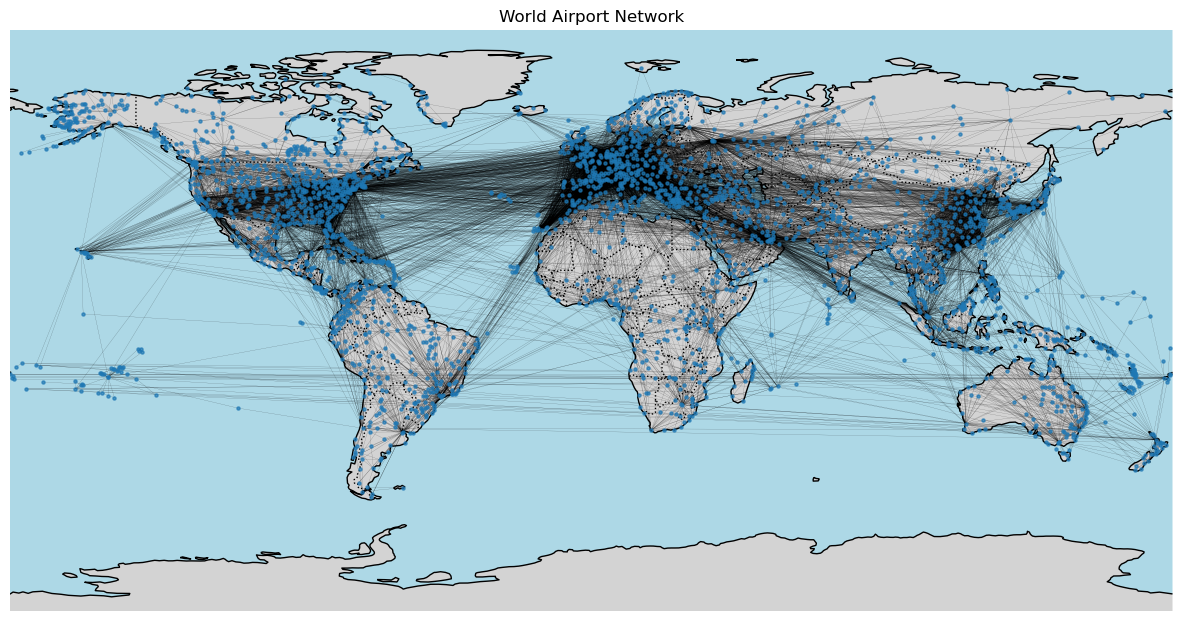

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx


# Set up the plot with Cartopy
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Add base map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

pos = {}
for n in G.nodes:
    try:
        #lat_str, lon_str = G.nodes[n]['pos'].split(',')
        #lat = float(lat_str.strip())
        #lon = float(lon_str.strip())
        pos[n] = (G.nodes('longitude')[n], G.nodes('latitude')[n])
    except (ValueError, AttributeError):
        continue  # Skip malformed or missing positions

# Plot nodes
lons = [pos[n][0] for n in G.nodes]
lats = [pos[n][1] for n in G.nodes]
#ax.scatter(lons, lats, s=10, color='red', alpha=0.7, transform=ccrs.PlateCarree(), zorder=5)

# Optionally plot edges (can be very dense)
#for u, v in G.edges():
#    lon1, lat1 = pos[u][0], pos[u][1]
#    lon2, lat2 = pos[v][0], pos[v][1]
#    ax.plot([lon1, lon2], [lat1, lat2], color='gray', linewidth=0.5, alpha=0.4, transform=ccrs.PlateCarree(), zorder=4)

nx.draw(G, pos=pos, node_size=5, alpha=0.7, edge_color='k', width=0.1)
plt.title("World Airport Network")
plt.show()


In [9]:
coms = nx.community.louvain_communities(G, resolution=0.7)
from collections import defaultdict
def partition_list_to_dict(partition_list):
    partition_dict = {}
    
    for community_id, nodes in enumerate(partition_list):
        for node in nodes:
            partition_dict[node] = community_id
    
    return partition_dict
coms = partition_list_to_dict(coms)

In [11]:
embedding = generate_embedding(G=G, parallel=False, M=1000, normalise_embedding=True, teleport=False, alpha=0.15)

In [12]:
pca = HellingerPCs(embedding, n_components=15)

In [13]:
clusters, roles, group_to_nodes = find_k_clusters(HellingerPC=pca, n_clusters=3)

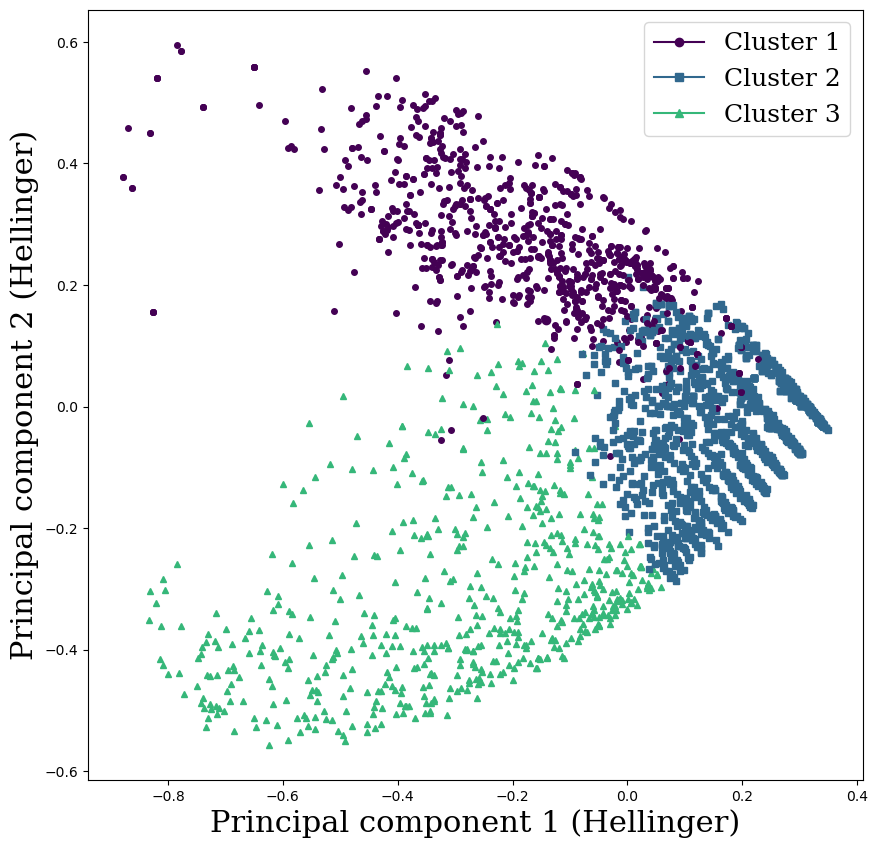

In [14]:
fig = plt.figure(figsize=(10, 10))
# Generate colors for each community
uniqs = np.unique(clusters)
colors = [plt.cm.viridis(i / len(uniqs)) for i in range(len(uniqs))]
node_colors = [colors[roles[node]] for node in G.nodes()]
markers = ['o', 's', '^']


for i in range(N):
    plt.plot(pca[i, 0], pca[i, 1], color=node_colors[i], marker=markers[clusters[i]], markersize=4)

plt.plot(pca[0, 0], pca[0, 1], color=node_colors[0], label='Cluster 1', marker=markers[clusters[0]])
plt.plot(pca[21, 0], pca[21, 1], color=node_colors[21], label='Cluster 2', marker=markers[clusters[21]])
plt.plot(pca[31, 0], pca[31, 1], color=node_colors[31], label='Cluster 3', marker=markers[clusters[31]])

plt.xlabel('Principal component 1 (Hellinger)', fontsize=22, font='serif')
plt.ylabel('Principal component 2 (Hellinger)', fontsize=22, font='serif')
plt.legend(prop={'family':'serif', 'size':18})

#plt.savefig('clusters2.pdf', bbox_inches='tight')
#plt.title('PCA')

Text(0.5, 0, 'Components')

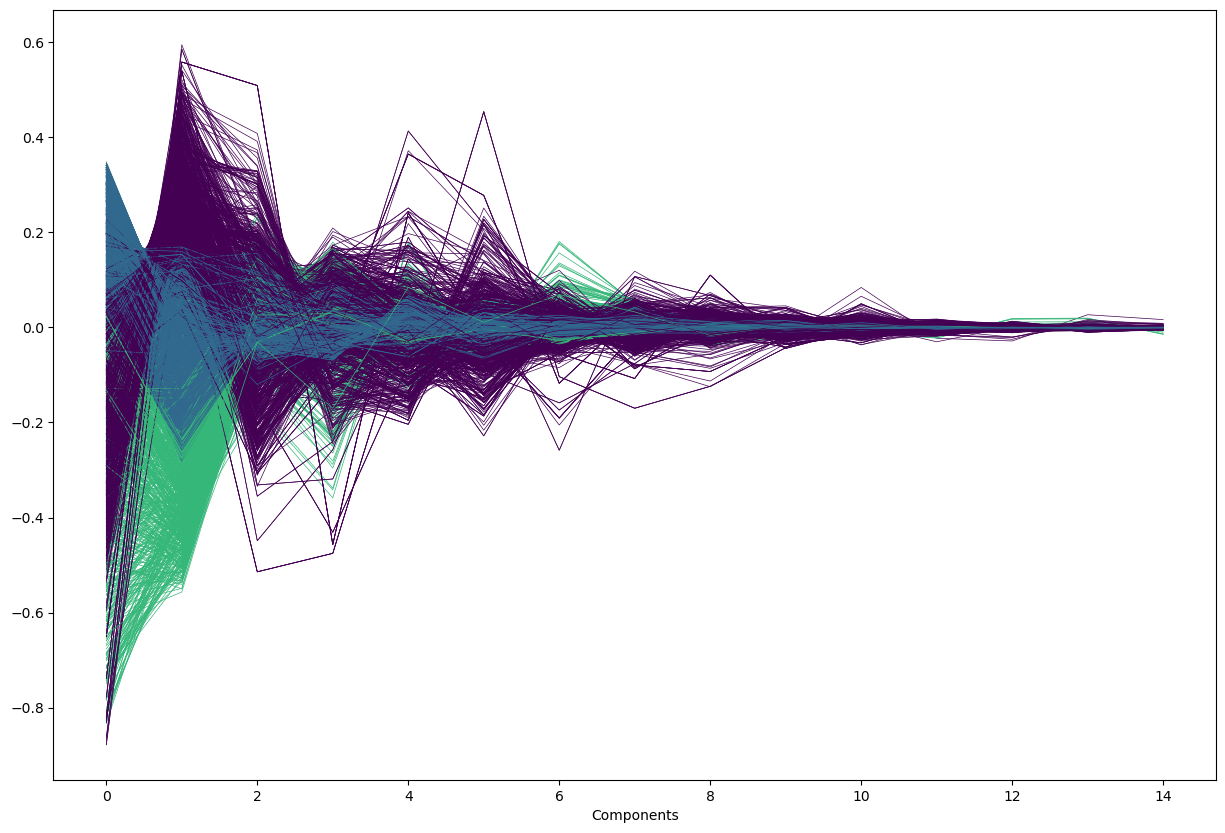

In [19]:
plt.figure(figsize=(15, 10))
for i in range(N):
    plt.plot(pca[i, :], color=node_colors[i], linewidth=0.5)

plt.xlabel('Components')
#plt.yscale('log')

In [21]:
labels = [G.nodes(data=True)[i]['type'] for i in G.nodes()]

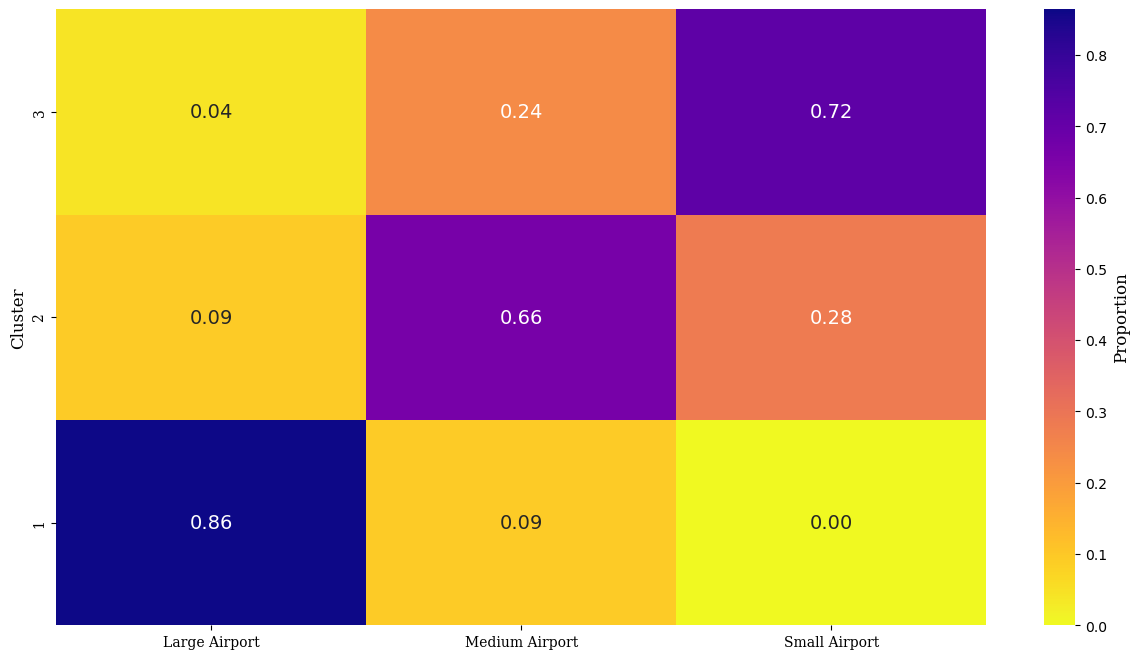

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({'Cluster': clusters, 'Label': labels})
# Cross-tab (normalize however you like: by column, by row, or absolute counts)
ct = pd.crosstab(df['Cluster'], df['Label'], normalize='columns')
ct = ct.drop(columns=['unknown', 'heliport', 'seaplane_base'])
plt.figure(figsize=(15,8))
ax = sns.heatmap(ct, annot=True, fmt=".2f", cmap="plasma_r",
            cbar_kws={'label': 'Proportion'},  annot_kws={"size": 14} )
cbar = ax.collections[0].colorbar

# Change the colorbar label font and size
cbar.ax.set_ylabel('Proportion', fontsize=12, fontname='serif')
plt.xlabel("")
plt.ylabel("Cluster", fontsize=12, font='serif')
#plt.title("Label vs. Cluster – normalized by column")
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['3', '2', '1'], font='serif')
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Large Airport', 'Medium Airport', 'Small Airport'], font='serif')
#plt.tight_layout()
plt.show()

In [25]:
unique_labels = ['medium_airport', 'seaplane_base', 'unknown', 'small_airport',
       'large_airport', 'heliport']
colors = [plt.cm.plasma(i / len(unique_labels)) for i in range(len(unique_labels))]
#colors = ['b', 'k', 'k', 'crimson', 'g', 'k']
markers = ['.', '.', '.', 's', '^', '.']
class_colors = []
class_markers = []
for i in tqdm(range(N)):
    for j in range(len(unique_labels)):
        if labels[i] == unique_labels[j]:
            class_colors.append(colors[j])
            class_markers.append(markers[j])
            

100%|██████████████████████████████████| 3214/3214 [00:00<00:00, 1113354.23it/s]


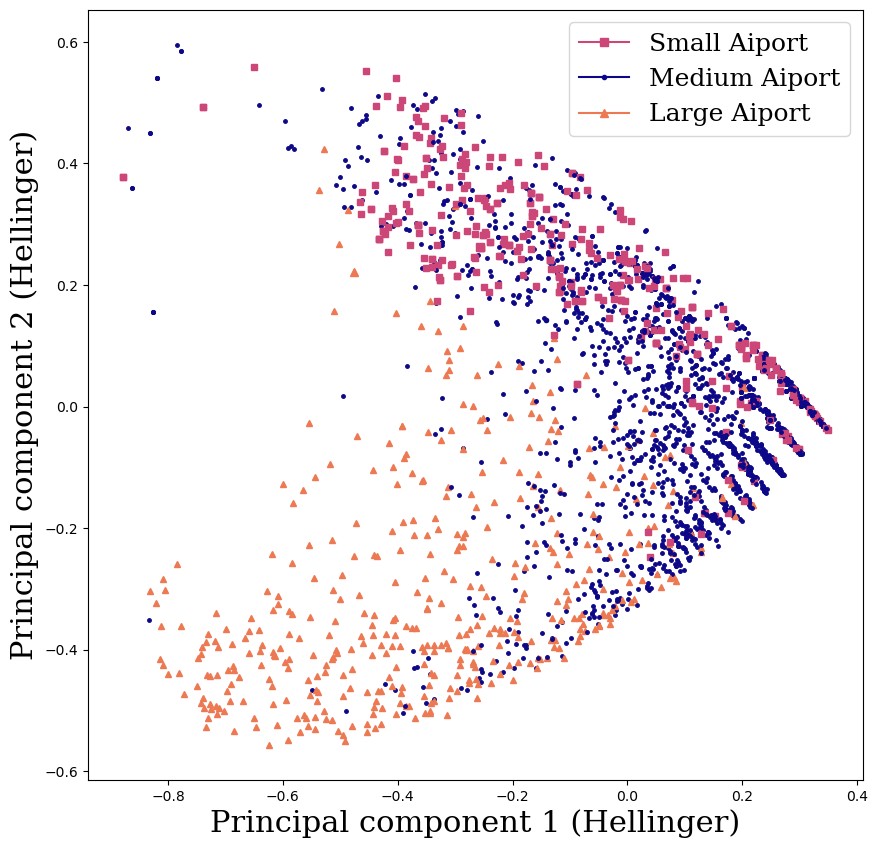

In [27]:
fig = plt.figure(figsize=(10, 10))
for i in range(N):
    if labels[i] == 'unknown' or labels[i] == 'heliport' or labels[i] == 'seaplane_base':
        continue
    plt.plot(pca[i, 0], pca[i, 1], marker=class_markers[i], color=class_colors[i], markersize=5)

plt.plot(pca[26, 0], pca[26, 1], marker=class_markers[26], color=class_colors[26], label='Small Aiport')
plt.plot(pca[0, 0], pca[0, 1], marker=class_markers[0], color=class_colors[0], label='Medium Aiport')
plt.plot(pca[4, 0], pca[4, 1], marker=class_markers[4], color=class_colors[4], label='Large Aiport')

#plt.plot(pca[3057, 0], pca[3057, 1], marker='o', color=class_colors[3057], label='Heliport')
#plt.plot(pca[2072, 0], pca[2072, 1], marker='o', color=class_colors[2072], label='Seaplane base')
#plt.plot(pca[201, 0], pca[201, 1], marker='o', color=class_colors[201], label='Not classified')


plt.xlabel('Principal component 1 (Hellinger)', fontsize=22, font='serif')
plt.ylabel('Principal component 2 (Hellinger)', fontsize=22, font='serif')
plt.legend(prop={'family':'serif', 'size':18})

#plt.savefig('main_roles_groundtruth.pdf', bbox_inches='tight')

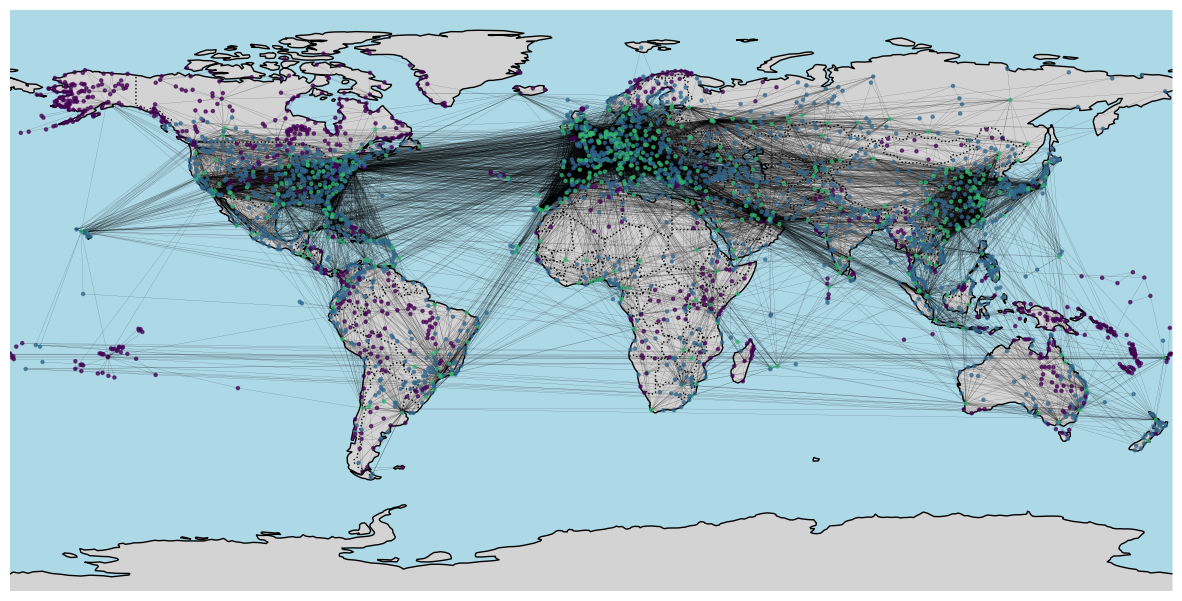

In [29]:
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Add base map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
nx.draw(G, pos=pos, node_size=5, alpha=0.7, edge_color='k', node_color=node_colors, width=0.1)

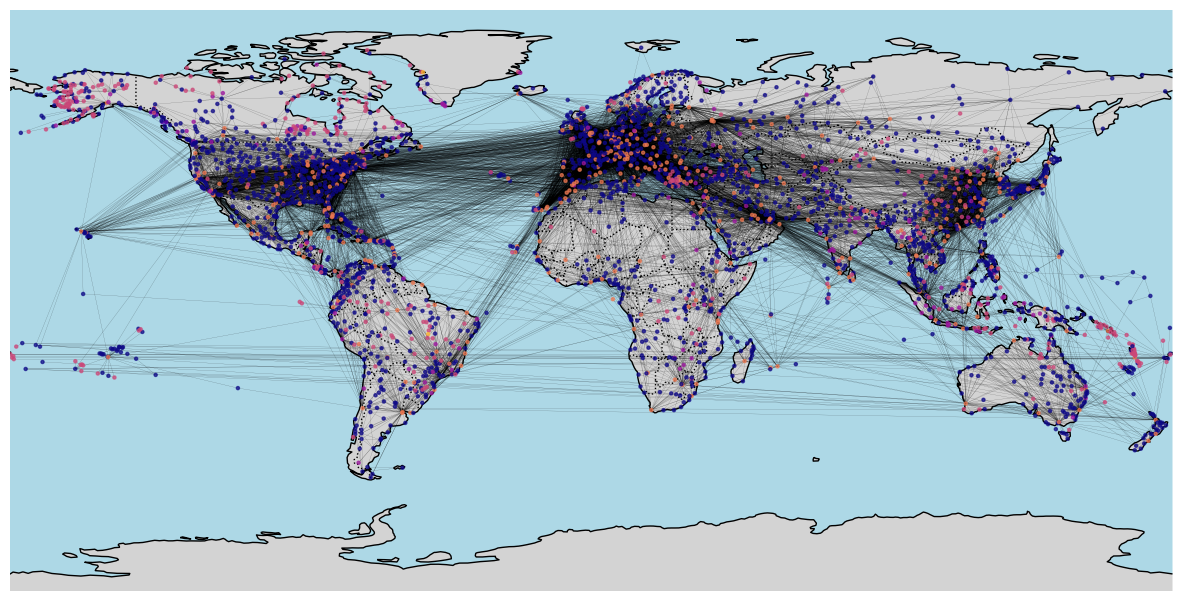

In [31]:
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Add base map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
nx.draw(G, pos=pos, node_size=5, alpha=0.7, edge_color='k', node_color=class_colors, width=0.1)

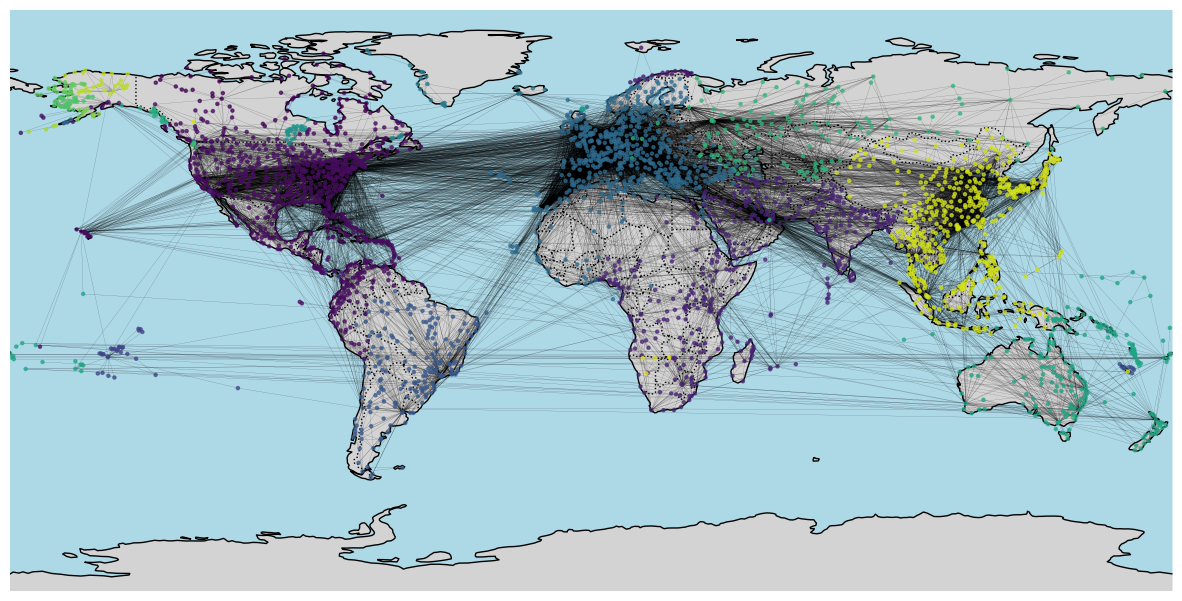

In [33]:
uniqs = np.unique(list(coms.values()))
colors = [plt.cm.viridis(i / len(uniqs)) for i in range(len(uniqs))]
node_colors_coms = [colors[coms[node]] for node in G.nodes()]
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Add base map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
nx.draw(G, pos=pos, node_size=5, alpha=0.7, edge_color='k', node_color=node_colors_coms, width=0.1)